In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

sns.set(rc={'figure.figsize':(11,8)})

In [2]:
df_src = pd.read_csv('data/titanic/train.csv')
df_src.head(1)
#df_src.isna().sum()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [3]:
def prepare_dataframe(df, train = True):
    if train:
        y = df['Survived']
        X = df.drop(['Survived'], axis = 1)
    else: 
        y = None
        X = df 
    X = X.fillna({'Age': X.Age.median()})
    X = X.fillna(0)
    X.set_index('PassengerId', inplace=True)
    X = X[['Pclass', 'Sex', 'Age', 'Fare']]
    X = pd.get_dummies(X)
    return X, y

In [4]:
# хочу сделать подбор гиперпараметров для deceision tree classifier
X, y = prepare_dataframe(df_src, train = True)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((596, 5), (596,), (295, 5), (295,))

In [6]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 3,random_state = 42)

In [7]:
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test), 

(0.8238255033557047, 0.8169491525423729)

In [8]:
# хочу прогнать по max_depth и получить графики на тесте
train_scores = []
test_scores = []

for i in range(1,50):
    clf = DecisionTreeClassifier(criterion='entropy', 
                                 min_samples_leaf=20, 
                                 min_samples_split=20,
                                 max_depth = i,
                                 random_state = 42)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train)) 
    test_scores.append(clf.score(X_test, y_test))
len(train_scores), len(test_scores)    

(49, 49)

In [9]:
df_graph = pd.DataFrame({'deepth': range(1,len(test_scores)+1), 
                         'train_scores':train_scores, 
                         'test_score': test_scores})

In [10]:
df_graph.head(5)

,deepth,train_scores,test_score
0,1,0.781879,0.796610
1,2,0.800336,0.779661
2,3,0.815436,0.816949
3,4,0.817114,0.769492
4,5,0.833893,0.779661


In [11]:
df_graph_melted = df_graph.melt(id_vars=['deepth'], 
                          value_vars=['train_scores', 'test_score'], 
                          var_name='type', 
                          value_name='score')
df_graph_melted.head(2)

,deepth,type,score
0,1,train_scores,0.781879
1,2,train_scores,0.800336


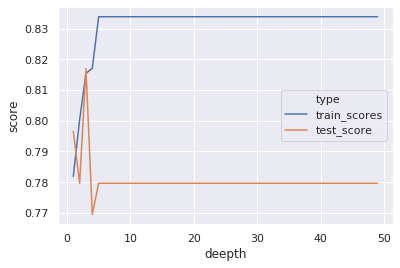

In [12]:
sns.lineplot(x='deepth', y='score', hue='type', data=df_graph_melted)

In [13]:
best_deepth = df_graph[df_graph['test_score'] == df_graph['test_score'].max()]['deepth']
clf = DecisionTreeClassifier(criterion='entropy', 
                             max_depth = best_deepth.iloc[0], 
                             min_samples_leaf=20, 
                             min_samples_split=20,
                             random_state = 42)
clf.fit(X,y) 

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [14]:
df_test = pd.read_csv('data/titanic/test.csv')
df_test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [15]:
X_res, _ = prepare_dataframe(df_test, train = False)
X_res.head()

,Pclass,Age,Fare,Sex_female,Sex_male
PassengerId,,,,,
892,3,34.5,7.8292,0,1
893,3,47.0,7.0000,1,0
894,2,62.0,9.6875,0,1
895,3,27.0,8.6625,0,1
896,3,22.0,12.2875,1,0


In [16]:
X_res['Survived'] = clf.predict(X_res)
X_res[['Survived']].to_csv('data/titanic/result.csv')